<a href="https://colab.research.google.com/github/Anu589/MNIST-Clustering-with-Autoencoder/blob/main/mnist_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##MNIST Image Clustering and Outlier Detection
###Overview
This script performs clustering and outlier detection on the MNIST dataset using an autoencoder for dimensionality reduction. The key steps include:

- Load and preprocess MNIST dataset

- Train an autoencoder to extract a compressed representation of digits

- Extract latent features (16-dimensional compressed features from the encoder)

- Clustering on latent features

- K-Means (with elbow method to find optimal K)

- Hierarchical Clustering

- DBSCAN

- Outlier Detection using Local Outlier Factor (LOF)

- Reconstruct images using the autoencoder

- Evaluate clustering performance using metrics like ARI, NMI, and silhouette score

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow
from shapely.geometry import Polygon, LineString
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, accuracy_score
from sklearn.linear_model import LogisticRegression

###2. Load and Preprocess MNIST Dataset
- The MNIST dataset is loaded using tensorflow.keras.datasets.mnist.

- The images are normalized to the range [0, 1] by dividing by 255.

- The images are flattened from (28, 28) to (784,) for input into the autoencoder.

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


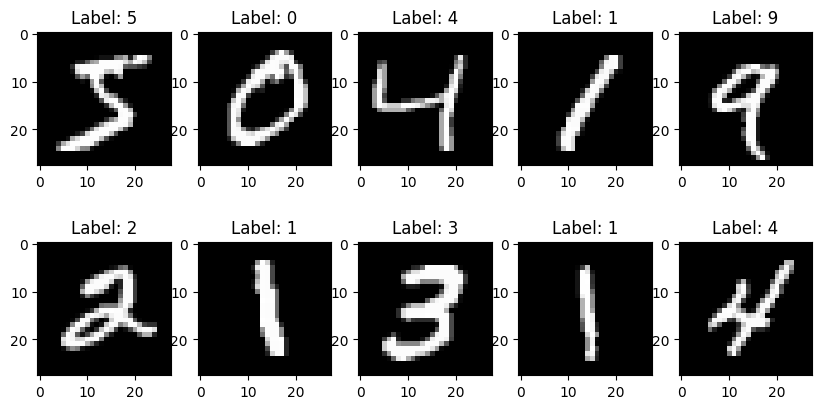

In [3]:
# Display 10 examples
plt.figure(figsize=(10, 5))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(x_train[i], cmap='gray')
  plt.title(f"Label: {y_train[i]}")
plt.show()

In [4]:
# Check the shape of the data
print("Training Data Shape:", x_train.shape)
print("Test Data Shape:", x_test.shape)

Training Data Shape: (60000, 28, 28)
Test Data Shape: (10000, 28, 28)


In [5]:
# Normalize the pixel values to the range [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [6]:
# Print dataset shapes
print(f"Training Data Shape: {x_train.shape}")
print(f"Test Data Shape: {x_test.shape}")

Training Data Shape: (60000, 28, 28)
Test Data Shape: (10000, 28, 28)


In [7]:
# Reshape for the neural network (Flattening images)
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

In [8]:
# Print dataset shapes
print(f"Training Data Shape: {x_train.shape}")
print(f"Test Data Shape: {x_test.shape}")

Training Data Shape: (60000, 784)
Test Data Shape: (10000, 784)


Q. Why normalize and flatten?

- Neural networks perform better with normalized inputs (values between 0 and 1).

- Fully connected layers require 1D inputs, so we flatten the images.

###3. Define and Train Autoencoder
The autoencoder consists of:

- Encoder: Reduces input size (28×28 = 784 pixels → 16 features)

- Decoder: Expands the 16 features back to 784 pixels (reconstruction)

- The model is trained using the Adam optimizer and Mean Squared Error (MSE) loss.

In [9]:
# Define Autoencoder
encoding_dim = 16  # Size of latent space(compressed representation of input)
input_img = Input(shape=(28*28,))
encoded = Dense(128, activation='relu')(input_img)  # using relu activation to reduce no. of neurons
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded) #compress input image to 16 values

In [10]:
# Decoding Process
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)  #expands the image
decoded = Dense(28*28, activation='sigmoid')(decoded)  # Output layer in 784 last layer has sigmoid as pixel values ranges from 0 to 1

In [11]:
autoencoder = Model(input_img, decoded) #input ->encoding -> decoding -> output
encoder = Model(input_img, encoded)  # Extract features using encoder

In [12]:
# Define the Decoder separately
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-3](encoded_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(encoded_input, decoder_layer)

In [13]:
autoencoder.compile(optimizer='adam', loss='mse') #adam is the optimizer and MSE is used to see how well original and output match

In [14]:
# Train Autoencoder
autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, validation_data=(x_test, x_test), verbose=1)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0988 - val_loss: 0.0389
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0359 - val_loss: 0.0282
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0273 - val_loss: 0.0243
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0243 - val_loss: 0.0228
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0229 - val_loss: 0.0215
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0217 - val_loss: 0.0207
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0209 - val_loss: 0.0201
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0200 - val_loss: 0.0193
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0195 - val_loss: 0.0189
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0189 - val_loss: 0.0184
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0185 - val_loss: 0.0179
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

- Input and output are the same because an autoencoder learns to reconstruct input.

- Mean Squared Error (MSE) is used to measure reconstruction quality.

###4. Extract Latent Features
- The encoder is used to extract 16-dimensional latent features from the test set.
- These encoded features will be used for clustering.

In [15]:
encoded_imgs = encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [17]:
# Show encoded images
# Number of images to display
num_images = 5
print("Encoded representations (first 5 samples):")
print(encoded_imgs[:num_images])

Encoded representations (first 5 samples):
[[ 0.        12.061951   7.982933  17.250366  17.412233   4.15569
  20.413797   0.        26.550169   0.        14.611607  20.106993
  23.23513    0.         6.5101976 10.989335 ]
 [ 0.         6.69648   12.0054     6.029697  15.1578865 20.749184
  15.150498   0.        11.311293   0.        14.326933  12.42381
  18.36546    0.        11.475137  29.799562 ]
 [ 0.         9.213233   8.4947815  3.603023  10.04955   15.692333
  32.19165    0.         9.439908   0.         7.619381  13.719697
  17.806679   0.         2.7895658 17.565458 ]
 [ 0.        11.504854  14.90449   14.090652  16.320005   6.553634
  14.502604   0.        19.910889   0.        11.075428  17.043514
  19.6943     0.        22.365757  20.236097 ]
 [ 0.        11.2575655  4.5165052 11.732129  10.034592   9.955038
  10.770369   0.        15.038166   0.        11.090144   2.0794675
  20.066511   0.        12.219996   6.435173 ]]


In [18]:
encoded_dim = encoded_imgs[0].shape[0]
encoded_dim

16

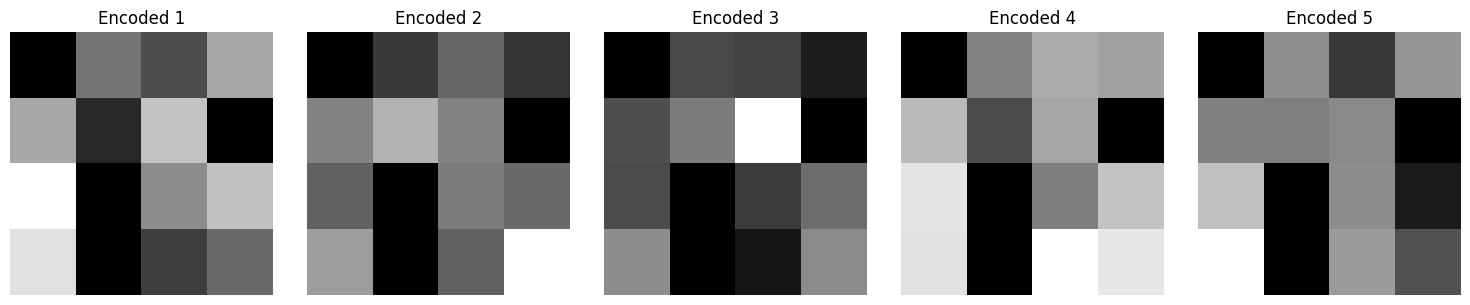

In [19]:
# Set up the figure
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

for i in range(num_images):
    encoded_reshaped = encoded_imgs[i].reshape((4, 4))  # Reshape to 4x4
    axes[i].imshow(encoded_reshaped, cmap='gray')
    axes[i].set_title(f"Encoded {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


**Reconstruct the images after encoding and decoding**

#####Method 1: using decoder to predict

In [ ]:
def show_images(original, reconstructed, num_images=5):
    for i in range(num_images):
        orig = (original[i].reshape(28, 28) * 255).astype(np.uint8)
        recon = (reconstructed[i].reshape(28, 28) * 255).astype(np.uint8)

        print(f"Original Image {i}:")
        cv2_imshow(orig)
        print(f"Reconstructed Image {i}:")
        cv2_imshow(recon)

In [ ]:
# Decode them back (reconstructing the images)
reconstructed_imgs = decoder.predict(encoded_imgs)

In [ ]:
show_images(original=x_test, reconstructed=reconstructed_imgs, num_images=5)

Original Image 0:


Reconstructed Image 0:


Original Image 1:


Reconstructed Image 1:


Original Image 2:


Reconstructed Image 2:


Original Image 3:


Reconstructed Image 3:


Original Image 4:


Reconstructed Image 4:


#####Method 2: Using Autoencoder to predict

In [ ]:
def show_images(original, reconstructed, num_images=5):
    for i in range(num_images):
        orig = (original[i].reshape(28, 28) * 255).astype(np.uint8)
        recon = (reconstructed[i].reshape(28, 28) * 255).astype(np.uint8)

        print(f"Original Image {i}:")
        cv2_imshow(orig)
        print(f"Reconstructed Image {i}:")
        cv2_imshow(recon)

In [ ]:
# Reconstruct images from the autoencoder
reconstructed_imgs = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
# Show reconstructed images
print("Reconstructed Images:")
show_images(x_test, reconstructed_imgs)

Reconstructed Images:
Original Image 0:


Reconstructed Image 0:


Original Image 1:


Reconstructed Image 1:


Original Image 2:


Reconstructed Image 2:


Original Image 3:


Reconstructed Image 3:


Original Image 4:


Reconstructed Image 4:


###5.  Clustering
####5.1.1. Elbow Method for Optimal K
- The elbow method is used to determine the optimal number of clusters (K) for K-Means.

- The second derivative of the distortion (inertia) is computed to find the elbow point.

In [20]:
def plot_elbow_method(data, max_k=15):
    distortions = []
    K_range = range(1, max_k + 1)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    diff = np.diff(distortions)  # First derivative
    diff2 = np.diff(diff)  # Second derivative
    elbow = np.argmin(diff2) + 2  # +2 because diff2 shifts indices twice

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, distortions, 'bo-', label="Distortion")
    plt.axvline(x=elbow, color='r', linestyle='--', label=f"Elbow at K={elbow}")
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal K')
    plt.legend()
    plt.show()

    print(f"Optimal number of clusters (Elbow Point) is: {elbow}")
    return elbow

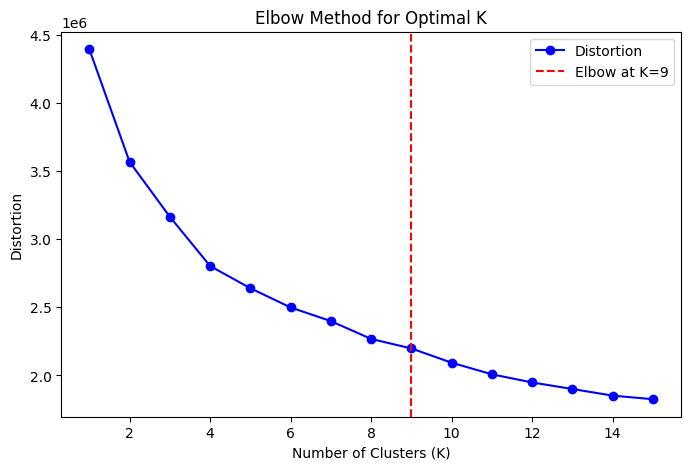

Optimal number of clusters (Elbow Point) is: 9


In [21]:
# Run Elbow Method on Encoded Images
optimal_k= plot_elbow_method(encoded_imgs, max_k=15)

####5.1.2. K-Means Clustering
K-Means is applied to the latent features using the optimal K determined by the elbow method.

In [22]:
# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_imgs)
cluster_centers = kmeans.cluster_centers_

In [23]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
encoded_pca = pca.fit_transform(encoded_imgs)
pca_centers = pca.transform(cluster_centers)

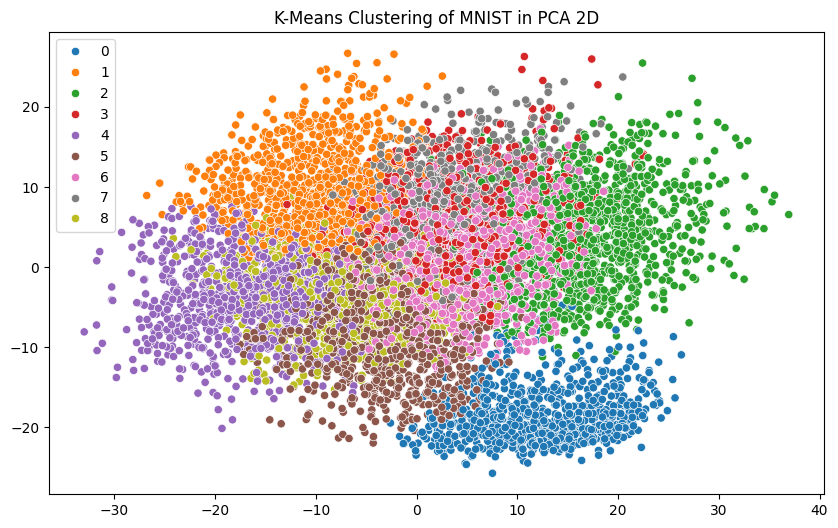

In [24]:
# Plot Clustering with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x=encoded_pca[:, 0], y=encoded_pca[:, 1], hue=kmeans_labels, palette='tab10')
plt.title("K-Means Clustering of MNIST in PCA 2D")
plt.show()

In [25]:
# Apply K-Means on the original encoded images
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_imgs)
cluster_centers = kmeans.cluster_centers_  # Get cluster centers in original space


In [26]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
encoded_pca = pca.fit_transform(encoded_imgs)  # Reduce data to 2D
pca_centers = pca.transform(cluster_centers)  # Transform cluster centers to 2D

In [27]:
import matplotlib.colors as mcolors

In [28]:
def plot_decision_boundaries(clusterer, X_pca, cluster_centers_pca, resolution=1000, show_centroids=True, optimal_k=None):
    # Define the grid
    mins = X_pca.min(axis=0) - 0.1
    maxs = X_pca.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))

    # Predict using KMeans in full space, then transform to PCA space
    Z_full_space = clusterer.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z_full_space.reshape(xx.shape)

    # Plot the decision boundaries
    plt.contourf(xx, yy, Z, alpha=0.4, cmap="Pastel2")
    plt.contour(xx, yy, Z, linewidths=1, colors='k')

    # Plot the data points
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusterer.labels_, cmap='viridis', s=10, alpha=0.8)

    # Plot the centroids
    if show_centroids:
        plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1],
                    marker='o', s=100, linewidths=2, facecolor='white', edgecolor='black', zorder=10)
    if optimal_k is not None:
        plt.title(f"K-Means Voronoi Diagram (Optimal K={optimal_k})")
    else:
        plt.title("K-Means Voronoi Diagram")

    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    plt.show()

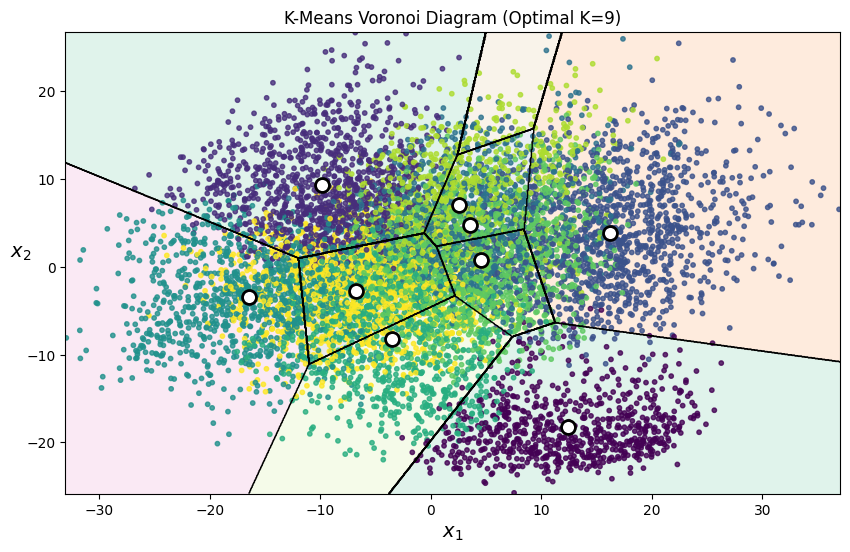

In [29]:
#  Pass PCA-transformed data and centroids
plt.figure(figsize=(10, 6))
plot_decision_boundaries(kmeans, encoded_pca, pca_centers, optimal_k=optimal_k)

####5.2. Hierarchical Clustering
Agglomerative Clustering is applied to the latent features.

Linkage matrix: [[5.44200000e+03 7.16700000e+03 1.35935692e+00 2.00000000e+00]
 [2.54100000e+03 6.86900000e+03 1.49147372e+00 2.00000000e+00]
 [3.64100000e+03 9.33500000e+03 1.54255766e+00 2.00000000e+00]
 ...
 [1.99930000e+04 1.99950000e+04 6.90075685e+02 6.95700000e+03]
 [1.99790000e+04 1.99940000e+04 8.61081250e+02 3.04300000e+03]
 [1.99960000e+04 1.99970000e+04 1.11741874e+03 1.00000000e+04]]


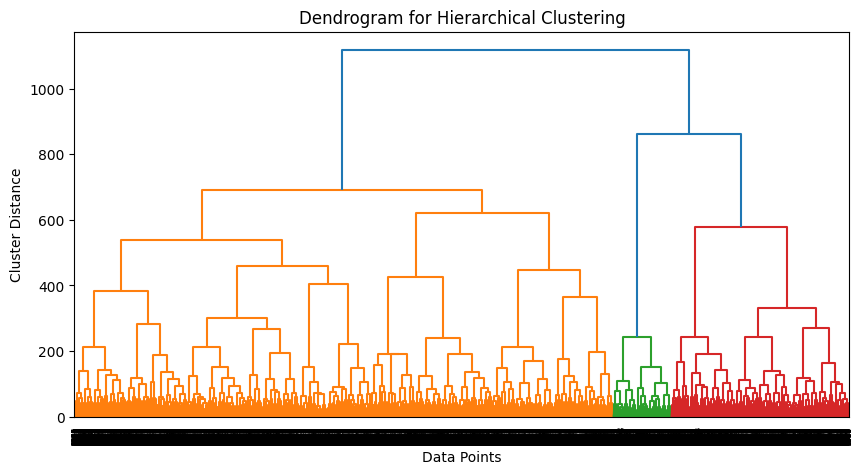

In [30]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Compute linkage matrix using Ward’s method
linkage_matrix = linkage(encoded_imgs, method='ward')
print("Linkage matrix:", linkage_matrix)
# Plot dendrogram
plt.figure(figsize=(10, 5))
sch.dendrogram(linkage_matrix)
plt.xlabel("Data Points")
plt.ylabel("Cluster Distance")
plt.title("Dendrogram for Hierarchical Clustering")
plt.show()


Best Choice:

1. fast, automatic approach → Use the Inconsistency Method
2. clusters have different sizes/densities → Use Distance Threshold
3. best clustering performance → Use Silhouette Score (best accuracy)

In [31]:
from scipy.cluster.hierarchy import fcluster

# Determine threshold using max-cluster formation
threshold = 0.7 * max(linkage_matrix[:, 2])  # 70% of max cluster distance
hierarchical_labels = fcluster(linkage_matrix, t=threshold, criterion='distance')

# Optimal K is the number of unique labels
optimal_k_h = len(set(hierarchical_labels))

print(f"Optimal K for Hierarchical Clustering: {optimal_k_h}")

Optimal K for Hierarchical Clustering: 3


In [32]:
# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(optimal_k_h)
hierarchical_labels = hierarchical.fit_predict(encoded_imgs)

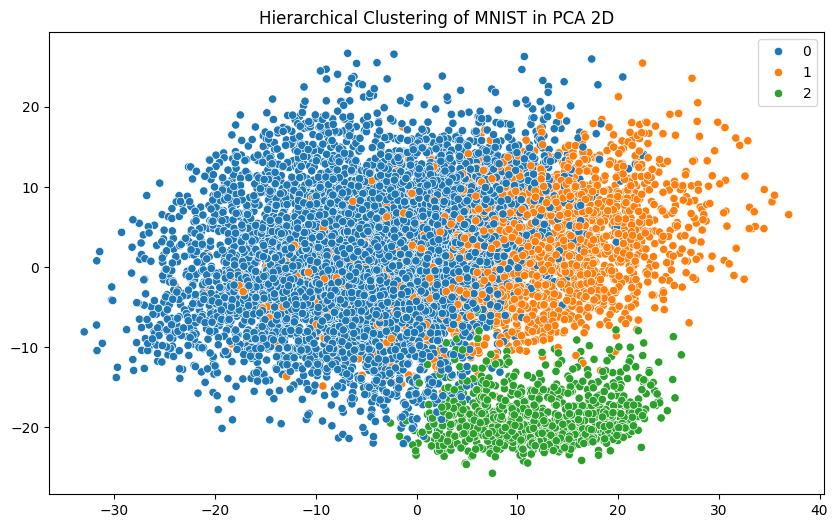

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=encoded_pca[:, 0], y=encoded_pca[:, 1], hue=hierarchical_labels, palette='tab10')
plt.title("Hierarchical Clustering of MNIST in PCA 2D")
plt.show()

####5.3. DBSCAN Clustering
DBSCAN is applied to the latent features.

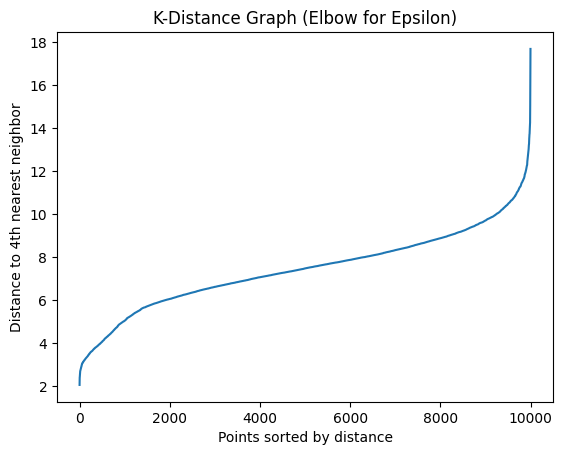

In [34]:
from sklearn.neighbors import NearestNeighbors

# Choose MinPts = 4 (rule of thumb: MinPts ≈ 2 × feature_dim)
MinPts = 4
neigh = NearestNeighbors(n_neighbors=MinPts)
neigh.fit(encoded_imgs)
distances, i = neigh.kneighbors(encoded_imgs)

# Sort and plot the k-th nearest distances
distances = np.sort(distances[:, MinPts-1])  # Get 4th nearest neighbor distances
plt.plot(distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {MinPts}th nearest neighbor")
plt.title("K-Distance Graph (Elbow for Epsilon)")
plt.show()


In [48]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

best_score = -1
best_params = None

# Try different values of epsilon and min_samples
for eps in np.arange(0.1, 4, 0.2):  ## Search for optimal ε (neighborhood radius) np.arange(start, stop, step)
    for min_pts in range(2, 10):   # Search for optimal min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_pts).fit(encoded_imgs)
        labels = dbscan.labels_

        # Ensure there are at least 2 clusters (excluding noise points)
        unique_labels = set(labels) - {-1}  # Remove noise (-1)
        if len(unique_labels) >= 2:  # At least 2 real clusters
            score = silhouette_score(encoded_imgs, labels)
            if score > best_score:
                best_score = score
                best_params = (eps, min_pts)

In [49]:
print(f"Optimal ε: {best_params[0]}, Optimal MinPts: {best_params[1]}")

Optimal ε: 3.900000000000001, Optimal MinPts: 9


In [50]:
# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])
dbscan_labels = dbscan.fit_predict(encoded_imgs)

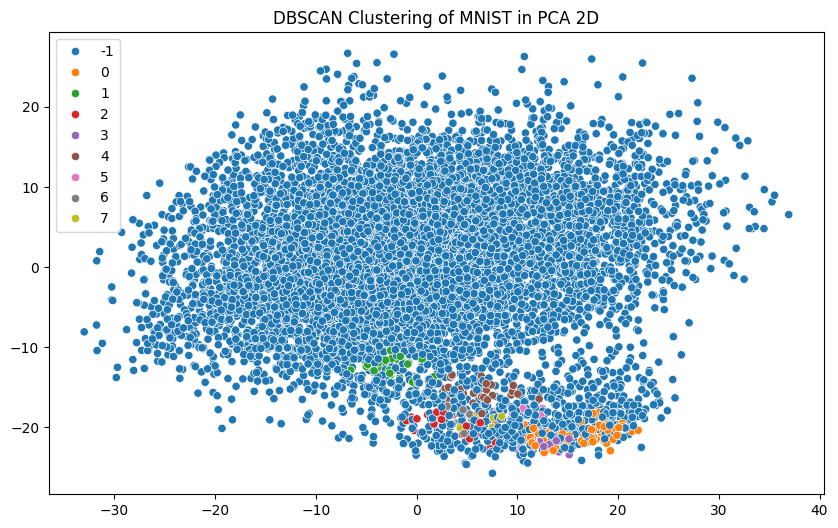

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=encoded_pca[:, 0], y=encoded_pca[:, 1], hue=dbscan_labels, palette='tab10')
plt.title("DBSCAN Clustering of MNIST in PCA 2D")
plt.show()

###6. Outlier Detection
Local Outlier Factor (LOF) is used to detect outliers in the latent space.

$\textbf{Local Outlier Factor (LOF) Algorithm}$

1. **Choose $k$ (number of neighbors):**  
   - The algorithm selects $k$ nearest neighbors for each data point.  
   - $k$ is usually set between **10 and 50** (default is 20).  

2. **Compute $k$-distance and $k$-nearest neighbors ($k$-NN):**  
   - The **$k$-distance** of a point $p$ is the distance to its $k$-th farthest neighbor.  
   - The **$k$-nearest neighbors** are the $k$ closest points to $p$.  

3. **Calculate the reachability distance for each neighbor:**  
   - The **reachability distance** of a point $p$ w.r.t a neighbor $o$:  
     $ \text{reachability\_dist}(p, o) = \max(\text{k-distance}(o), \text{distance}(p, o)) $  
   - This prevents small distances from dominating the results.  

4. **Compute the local reachability density (LRD):**  
   - The **LRD** of a point $p$ is the inverse of the average reachability distance to its $k$ neighbors:  
     $ \text{LRD}(p) = \frac{k}{\sum\limits_{o \in k\text{-NN}(p)} \text{reachability\_dist}(p, o)} $  
   - A lower LRD means a point is in a **low-density region** (potentially an outlier).  

5. **Calculate the LOF score for each point:**  
   - LOF compares the LRD of $p$ with its neighbors:  
     $ \text{LOF}(p) = \frac{\sum\limits_{o \in k\text{-NN}(p)} \frac{\text{LRD}(o)}{\text{LRD}(p)}}{k} $  
   - If $\text{LOF} \approx 1$, $p$ has a density similar to its neighbors (normal).  
   - If $\text{LOF} \gg 1$, $p$ is in a low-density region (outlier).  

6. **Classify Outliers:**  
   - If **LOF score > threshold** (typically **> 1.5**), the point is flagged as an outlier.  

$\textbf{Complexity Analysis}$

- **Computing k-NN:** $O(n \log n)$ with efficient methods (KD-Trees).  
- **LOF computation:** $O(nk)$, making it suitable for medium-sized datasets.  



In [52]:
# Outlier Detection using Local Outlier Factor (LOF) using 20 neighbour points
lof = LocalOutlierFactor(n_neighbors=20)
outlier_scores = lof.fit_predict(encoded_imgs)
outlier_indices = np.where(outlier_scores == -1)[0]

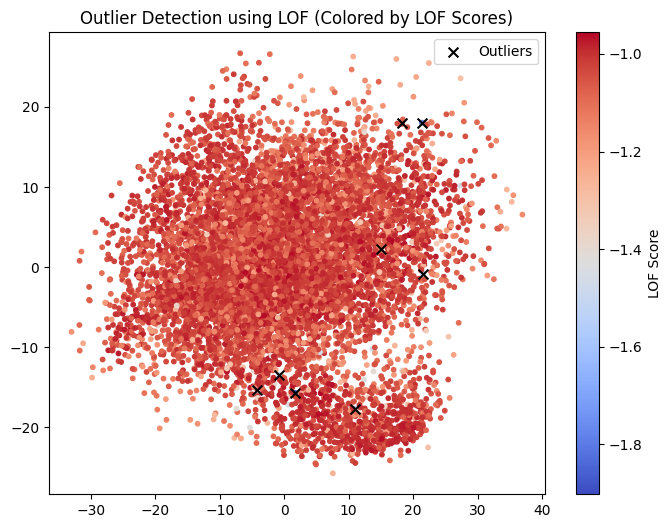

In [53]:
plt.figure(figsize=(8, 6))

# Color all points by their LOF scores
sc = plt.scatter(encoded_pca[:, 0], encoded_pca[:, 1],
                 c=lof.negative_outlier_factor_, cmap='coolwarm', s=10)

# Mark outliers with black crosses
plt.scatter(encoded_pca[outlier_indices, 0], encoded_pca[outlier_indices, 1],
            c='black', marker='x', s=50, label='Outliers')
cbar = plt.colorbar(sc)
cbar.set_label("LOF Score")

plt.legend()
plt.title("Outlier Detection using LOF (Colored by LOF Scores)")
plt.show()


###7. Image Reconstruction
The autoencoder is used to reconstruct images from the test set.

Original and reconstructed images are displayed side by side.

In [83]:
# Use the cluster centroids as input to the decoder
reconstructed_from_centroids = decoder.predict(cluster_centers)

# Reshape the reconstructed images to 28x28
reconstructed_from_centroids = reconstructed_from_centroids.reshape(-1, 28, 28)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


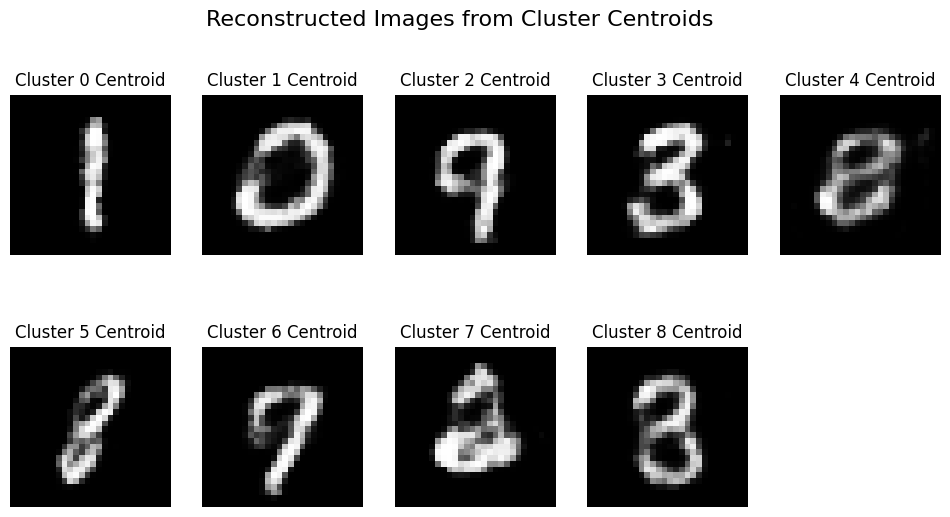

In [85]:
# Plot the reconstructed images for each cluster centroid
plt.figure(figsize=(12, 6))
for i in range(optimal_k):
    plt.subplot(2, 5, i + 1)
    plt.imshow(reconstructed_from_centroids[i], cmap='gray')
    plt.title(f"Cluster {i} Centroid")
    plt.axis('off')
plt.suptitle("Reconstructed Images from Cluster Centroids", fontsize=16)
plt.show()

### 8. **Clustering Evaluation Metrics**  

##### **1. Adjusted Rand Index (ARI)**  

ARI measures the similarity between the ground truth labels $ y_{\text{true}} $ and the clustering labels $ y_{\text{pred}} $, adjusted for chance.

**Formula**  

$$
ARI = \frac{\sum_{ij} \binom{n_{ij}}{2} - \left[ \sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2} \right] / \binom{n}{2}}{\frac{1}{2} \left[ \sum_i \binom{a_i}{2} + \sum_j \binom{b_j}{2} \right] - \left[ \sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2} \right] / \binom{n}{2}}
$$

where:
- $ n_{ij} $ is the number of samples shared between true cluster $ i $ and predicted cluster $ j $.
- $ a_i $ is the number of elements in true cluster $ i $.
- $ b_j $ is the number of elements in predicted cluster $ j $.
- $ n $ is the total number of samples.

ARI ranges from **-1 to 1**, where:
- **1** indicates perfect clustering.
- **0** means random clustering.
- **Negative values** suggest worse-than-random clustering.



##### **2. Normalized Mutual Information (NMI)**  

NMI measures how much information is shared between true and predicted clusters.

**Formula**  

$$
NMI = \frac{2 I(Y_{\text{true}}, Y_{\text{pred}})}{H(Y_{\text{true}}) + H(Y_{\text{pred}})}
$$

where:
- $ I(Y_{\text{true}}, Y_{\text{pred}}) $ is the mutual information between true and predicted clusters.
- $ H(Y) $ represents entropy.

NMI ranges from **0 to 1**, where:
- **1** means perfect clustering.
- **0** means no mutual information.


##### **3. Silhouette Score**  

Silhouette score measures how well clusters are separated.

**Formula**  

$$
S = \frac{b - a}{\max(a, b)}
$$

where:
- $ a $ is the average intra-cluster distance.
- $ b $ is the average nearest-cluster distance.

Silhouette score ranges from **-1 to 1**, where:
- **1** means well-separated clusters.
- **0** means overlapping clusters.
- **Negative values** indicate incorrect clustering.


In [59]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Compute ARI and NMI (for K-Means)
ari_kmeans = adjusted_rand_score(y_test, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(y_test, kmeans_labels)
silhouette_kmeans = silhouette_score(encoded_imgs, kmeans_labels)

print(f"K-Means Clustering Evaluation:")
print(f"Adjusted Rand Index (ARI): {ari_kmeans:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_kmeans:.4f}")
print(f"Silhouette Score: {silhouette_kmeans:.4f}")


K-Means Clustering Evaluation:
Adjusted Rand Index (ARI): 0.2590
Normalized Mutual Information (NMI): 0.3918
Silhouette Score: 0.1448


In [60]:
valid_dbscan_mask = dbscan_labels != -1  # Exclude outliers
valid_labels = dbscan_labels[valid_dbscan_mask]

# Compute Silhouette Score only if we have at least 2 valid clusters
if len(set(valid_labels)) > 1:
    silhouette_dbscan = silhouette_score(encoded_imgs[valid_dbscan_mask], valid_labels)
else:
    silhouette_dbscan = None  # Not computable

# Compute ARI & NMI
ari_dbscan = adjusted_rand_score(y_test, dbscan_labels)
nmi_dbscan = normalized_mutual_info_score(y_test, dbscan_labels)

print(f" DBSCAN Clustering Metrics**:")
print(f"   - Adjusted Rand Index (ARI): {ari_dbscan:.4f}")
print(f"   - Normalized Mutual Information (NMI): {nmi_dbscan:.4f}")
print(f"   - Silhouette Score: {silhouette_dbscan:.4f}" if silhouette_dbscan else "   - Silhouette Score: Not computable (only 1 cluster)")

 DBSCAN Clustering Metrics**:
   - Adjusted Rand Index (ARI): -0.0002
   - Normalized Mutual Information (NMI): 0.0399
   - Silhouette Score: 0.2246


In [61]:
# Hierarchical Clustering Metrics
ari_hierarchical = adjusted_rand_score(y_test, hierarchical_labels)
nmi_hierarchical = normalized_mutual_info_score(y_test, hierarchical_labels)
silhouette_hierarchical = silhouette_score(encoded_imgs, hierarchical_labels)
print(f"\n Hierarchical Clustering Metrics**:")
print(f"   - Adjusted Rand Index (ARI): {ari_hierarchical:.4f}")
print(f"   - Normalized Mutual Information (NMI): {nmi_hierarchical:.4f}")
print(f"   - Silhouette Score: {silhouette_hierarchical:.4f}")


 Hierarchical Clustering Metrics**:
   - Adjusted Rand Index (ARI): 0.1060
   - Normalized Mutual Information (NMI): 0.3386
   - Silhouette Score: 0.1594


1. Silhouette Score ($S$) and Cluster Density

- Higher $S$ means clusters are dense (compact) and well-separated.

- Lower $S$ means clusters are more sparse and overlapping, indicating poor clustering.

2. Adjusted Rand Index (ARI) and Compactness of Clusters

- If clusters are dense, the ARI score is high because samples are well-grouped.

- If clusters are sparse, ARI drops, as points are assigned incorrectly to multiple clusters.

3. Normalized Mutual Information (NMI) and Cluster Spread

- NMI is high when clusters are well-separated and match ground truth.

- If clusters are spread out (sparse clusters), NMI drops, as labels become uncertain.

---

###9. Semi-Supervised Learning Using K-Means

##### 9.1. Select 50 Representative Images Using K-Means

In [62]:
num_clusters = 50  # Select 50 representative images
kmeans_representative = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_representative.fit(encoded_imgs)

KMeans(n_clusters=50, random_state=42)

- Goal: Find 50 representative images from the dataset.

- Use K-Means on the encoded features (latent space) to cluster the images.

#####9.2. Find the closest image to each centroid

In [63]:
closest_indices = []
for i in range(num_clusters):
    cluster_points = np.where(kmeans_representative.labels_ == i)[0]  # Find images in this cluster
    centroid = kmeans_representative.cluster_centers_[i]  # Cluster center
    distances = np.linalg.norm(encoded_imgs[cluster_points] - centroid, axis=1) # Distance from centroid
    closest = cluster_points[np.argmin(distances)]  # Closest image to centroid
    closest_indices.append(closest)

- Finds 1 image per cluster that is closest to the cluster center.

- These images are representative of each cluster.

#####9.3. Train based on these images

In [64]:
X_train_selected = x_train[closest_indices]
y_train_selected = y_train[closest_indices]

#####9.4. Visualize the representative images

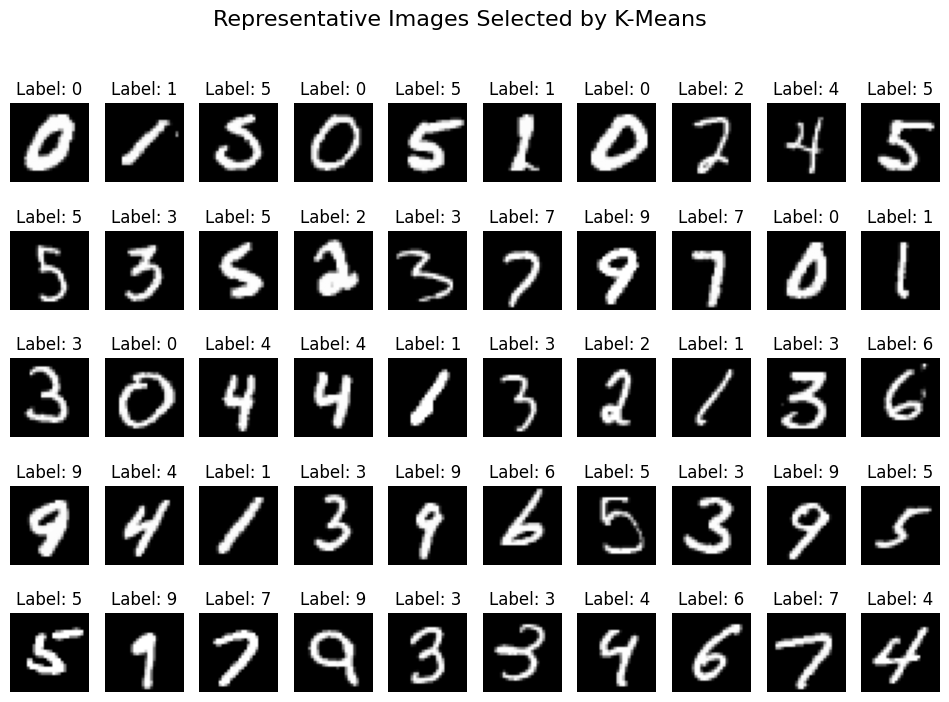

In [65]:
plt.figure(figsize=(12, 8))
for i in range(num_clusters):
    plt.subplot(5, 10, i + 1)
    plt.imshow(X_train_selected[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train_selected[i]}")
    plt.axis('off')
plt.suptitle("Representative Images Selected by K-Means", fontsize=16)
plt.show()

#####9.5.Train logistic regression on the selected images

In [66]:
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_selected, y_train_selected)

LogisticRegression(max_iter=200)

#####9.6. Evaluate on the full test set

In [67]:
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using {num_clusters} representative images: {accuracy:.4f}")

Accuracy using 50 representative images: 0.6028


- Tests the model on the full MNIST test set and prints the accuracy.

- This shows how well just 50 images can represent the dataset.


#####9.7. Kmean Clustering

In [68]:
kmeans_semi = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_semi.fit(encoded_imgs)

KMeans(n_clusters=50, random_state=42)

- Performs K-Means clustering again on the encoded features to create 50 clusters.

- These clusters are used for label propagation.

###10. Semi-Supervised Learning with Label Propagation

#####10.1. Assigning Labesl

- Now, instead of using only 50 images, we use label propagation to label entire clusters.

In [69]:
# Assign labels only to 1 image per cluster
labels_propagated = np.full(len(y_train), -1)  # -1 means "unlabeled"
for i in range(num_clusters):
    cluster_points = np.where(kmeans_semi.labels_ == i)[0]
    centroid = kmeans_semi.cluster_centers_[i]
    distances = np.linalg.norm(encoded_imgs[cluster_points] - centroid, axis=1)
    closest = cluster_points[np.argmin(distances)]
    labels_propagated[closest] = y_train[closest]

- One image per cluster is given a ground-truth label.

- The rest are still unlabeled (-1).

In [70]:
# Assign Labels to One Image per Cluster
labels_propagated_test = np.full(len(y_test), -1)  # # -1 means "unlabeled"
for i in range(num_clusters):
    cluster_points = np.where(kmeans_semi.labels_ == i)[0]  # Find images in this cluster
    centroid = kmeans_semi.cluster_centers_[i]
    distances = np.linalg.norm(encoded_imgs[cluster_points] - centroid, axis=1)
    closest = cluster_points[np.argmin(distances)]   # Closest image to centroid
    labels_propagated_test[closest] = y_test[closest] # Assign true label to this image

Repeats the process for the test set:

  - Finds the closest image per cluster.

  - Assigns its true label.

In [71]:
# Propagate labels to entire clusters in the test set
for i in range(num_clusters):
    cluster_points = np.where(kmeans_semi.labels_ == i)[0]
    if labels_propagated_test[cluster_points[0]] != -1:
        labels_propagated_test[cluster_points] = labels_propagated_test[cluster_points[0]]


- Assigns the same label to all points in a cluster (label propagation).

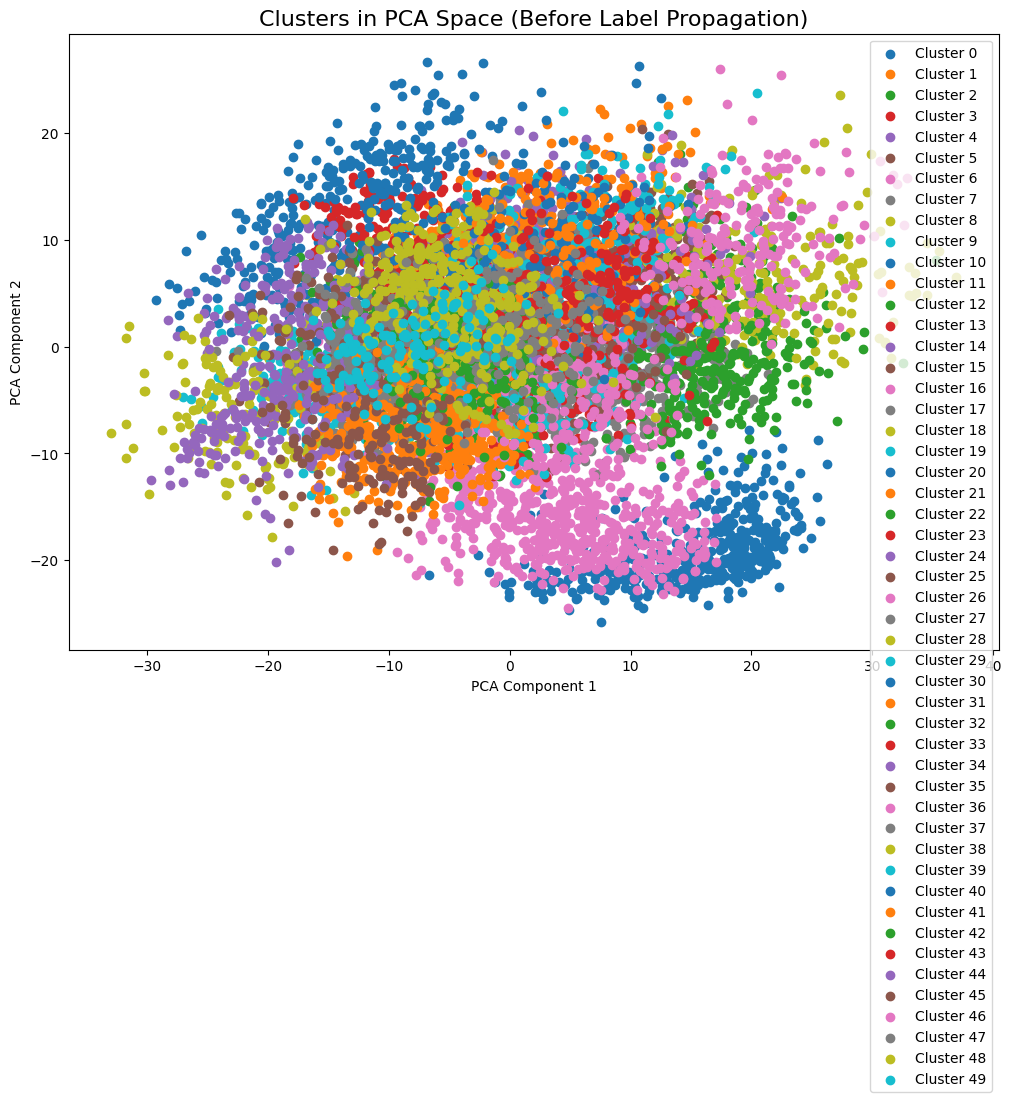

In [72]:
# Visualize the label propagation process
plt.figure(figsize=(12, 8))
for i in range(num_clusters):
    cluster_points = np.where(kmeans_semi.labels_ == i)[0]
    plt.scatter(encoded_pca[cluster_points, 0], encoded_pca[cluster_points, 1], label=f"Cluster {i}")
plt.title("Clusters in PCA Space (Before Label Propagation)", fontsize=16)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

#####10.2.Train Logistic Regression on Propagated Labels

In [73]:
X_labeled = x_train[labels_propagated != -1]
y_labeled = labels_propagated[labels_propagated != -1]

In [74]:
clf_semi = LogisticRegression(max_iter=200)
clf_semi.fit(X_labeled, y_labeled)

LogisticRegression(max_iter=200)

- Uses all images that received labels for training.

####10.3 Tests the model after label propagation.

In [75]:
# Evaluate on the full test set
y_pred_semi = clf_semi.predict(x_test)
accuracy_semi = accuracy_score(y_test, y_pred_semi)
print(f"Semi-supervised accuracy using label propagation: {accuracy_semi:.4f}")

Semi-supervised accuracy using label propagation: 0.6028


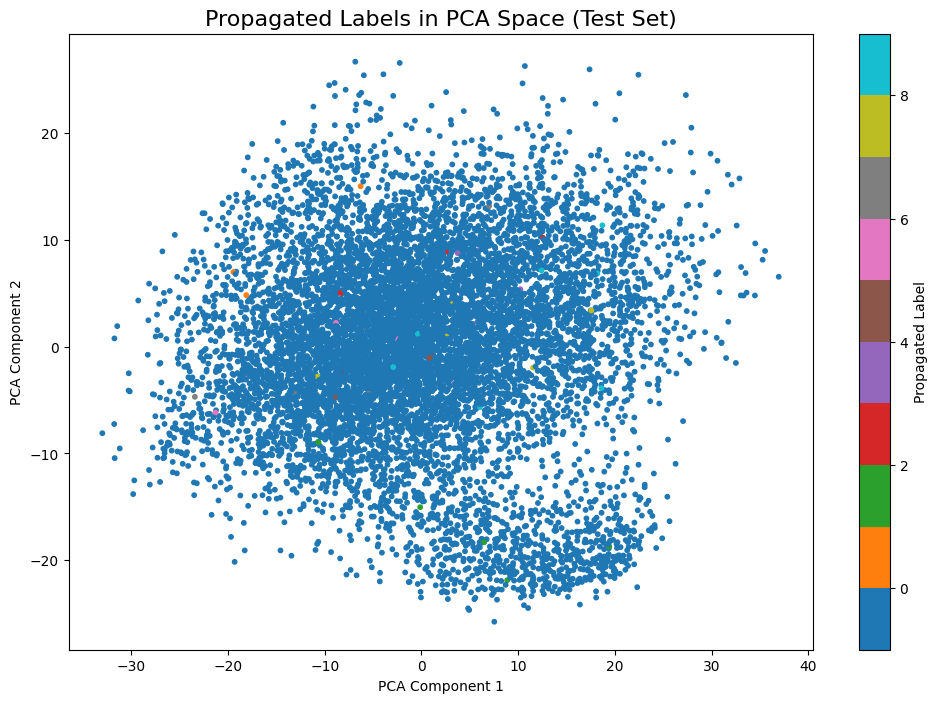

In [76]:
# Visualize the propagated labels in PCA space
plt.figure(figsize=(12, 8))
plt.scatter(encoded_pca[:, 0], encoded_pca[:, 1], c=labels_propagated_test, cmap='tab10', s=10)
plt.title("Propagated Labels in PCA Space (Test Set)", fontsize=16)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Propagated Label")
plt.show()

In [80]:
autoencoder.fit(X_labeled, X_labeled, epochs=50, batch_size=256, validation_data=(x_test, x_test))  # Get latent space representation
encoded_test_imgs_semi = encoder.predict(x_test)
reconstructed_test_imgs_semi = decoder.predict(encoded_test_imgs_semi)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0123 - val_loss: 0.0141
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 0.0114 - val_loss: 0.0146
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - loss: 0.0106 - val_loss: 0.0151
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.0099 - val_loss: 0.0155
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.0093 - val_loss: 0.0159
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.0087 - val_loss: 0.0162
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.0082 - val_loss: 0.0165
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step - loss: 0.0078 - val_loss: 0.0167
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - loss: 0.0073 - val_loss: 0.0169
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.0069 - val_loss: 0.0171
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - loss: 0.0065 - val_loss:

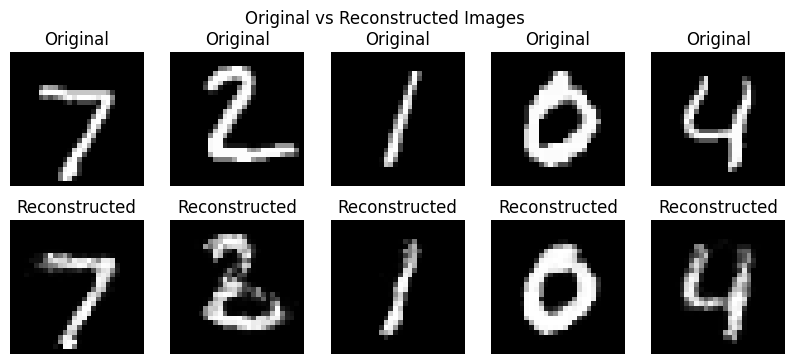

In [82]:
import matplotlib.pyplot as plt

num_images = 5  # Number of images to display
plt.figure(figsize=(10, 4))
for i in range(num_images):
    # Original Image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title("Original")

    # Reconstructed Image
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(reconstructed_test_imgs_semi[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title("Reconstructed")

plt.suptitle("Original vs Reconstructed Images")
plt.show()
